In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class State:
    """a container to hold an object"""

    def __init__(self, mass, x, y, u, v):
        self.mass = mass
        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        assert self.mass == other.mass
        return State(self.mass,
                     self.x + other.x, self.y + other.y,
                     self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        assert self.mass == other.mass
        return State(self.mass,
                     self.x - other.x, self.y - other.y,
                     self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        assert self.mass == other.mass
        return State(self.mass,
                     other * self.x, other * self.y,
                     other * self.u, other * self.v)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        return f"{self.mass:10.6f}: {self.x:10.6f} {self.y:10.6f} {self.u:10.6f} {self.v:10.6f}"

In [3]:
class SolarSystem:
    """model the gravitational interaction of three stars"""

    def __init__(self, M_star, *, m_planets=None, a_planets=None, SMALL=1.e-30):
        """pos is a tuple of x-y coords of the stars"""

        self.G = 4 * np.pi**2  # units AU**3 / (solar mass * year**2)
        self.M_star = M_star

        # store the history of the solar system
        self.history = []

        # we have the star and planets
        self.nobjects = len(m_planets) + 1
        
        # current solar system
        system = []
        
        # store the star 
        system.append(State(M_star, 0.0, 0.0, 0.0, 0.0))

        # store the planets
        assert len(m_planets) == len(a_planets)

        for m, a in zip(m_planets, a_planets):
            # pick a random angle and then set the velocity to be circular
            phi = np.random.uniform(0, 2.0*np.pi)
            v_circ = np.sqrt(self.G * self.M_star / a)
            system.append(State(m,
                                a*np.cos(phi), a*np.sin(phi),
                                -v_circ*np.sin(phi), v_circ*np.cos(phi)))
            
        # store the initial state
        self.history.append(system)

        self.SMALL = SMALL

        self.time = [0.0]

    def npts(self):
        """return the number of integration points"""
        return len(self.time)

    def rhs(self, states):
        """states is (State, State, ...)"""

        ydots = []

        for istar in range(len(states)):

            # compute the space derivatives

            dxdt = states[istar].u
            dydt = states[istar].v

            # compute the velocity derivatives
            dudt = 0.0
            dvdt = 0.0

            for jstar in range(len(states)):
                if istar == jstar:
                    continue
                else:
                    dx = states[jstar].x - states[istar].x
                    dy = states[jstar].y - states[istar].y

                    r = np.sqrt(dx**2 + dy**2) + self.SMALL

                    dudt += self.G * states[jstar].mass * dx / r**3
                    dvdt += self.G * states[jstar].mass * dy / r**3

            ydots.append(State(states[istar].mass, dxdt, dydt, dudt, dvdt))

        return ydots

    def single_step(self, states_old, dt):
        """take a single Verlet step (kick-drift-kick)"""

        ydot_old = self.rhs(states_old)

        states_new = []
        for istate in range(len(states_old)):
            
            # kick
            uhalf = states_old[istate].u + 0.5 * dt * ydot_old[istate].u
            vhalf = states_old[istate].v + 0.5 * dt * ydot_old[istate].v

            # drift
            xnew = states_old[istate].x + dt * uhalf
            ynew = states_old[istate].y + dt * vhalf            

            states_new.append(State(states_old[istate].mass,
                                    xnew, ynew,
                                    uhalf, vhalf))
            
        # evaluate the acceleration again -- this works only because
        # the acceleration does not depend on velocity
        ydot_new = self.rhs(states_new)

        for istate in range(len(states_new)):

            # kick
            states_new[istate].u += 0.5 * dt * ydot_new[istate].u
            states_new[istate].v += 0.5 * dt * ydot_new[istate].v            

        return states_new

    def integrate(self, dt, tmax):
        """integrate our solar system using the velocity-Verlet method"""

        t = self.time[-1]
        
        while t < tmax:
            
            states_old = self.history[-1]

            if t + dt > tmax:
                dt = tmax-t

            states_new = self.single_step(states_old, dt)

            t += dt
            
            self.time.append(t)
            self.history.append(states_new)

In [4]:
s = SolarSystem(1.0, m_planets=[0.001], a_planets=[1])

In [5]:
s.integrate(0.0001, 1.e3)

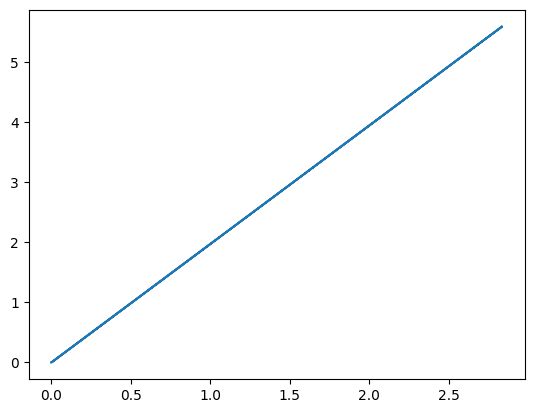

In [6]:
fig, ax = plt.subplots()

for n in range(s.nobjects-1):
    xs = [q[n].x for q in s.history]
    ys = [q[n].y for q in s.history]    
    ax.plot(xs, ys)

In [7]:
xs = [q[0].x for q in s.history]

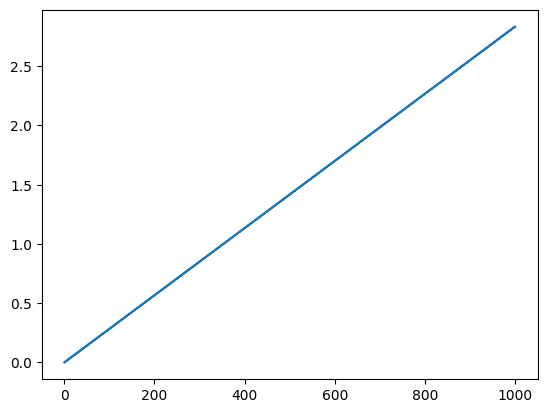

In [10]:
fig, ax = plt.subplots()
ax.plot(s.time, xs)